# ps

> persistent scatterers identification

In [ ]:
#| default_exp ps

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
from matplotlib import pyplot as plt
import colorcet

In [ ]:
#| export
import numpy as np
from typing import Union
import math
import numba
try:
    import cupy as cp
except:
    pass

In [ ]:
#| export
@numba.jit(nopython=True, cache=True,parallel=True)
def _amp_disp_numba(rslc):
    epsilon = np.float32(1e-30)
    nlines, width = rslc.shape[:-1]
    amp_disp = np.empty((nlines,width),dtype=np.float32)
    for j in numba.prange(nlines):
        for i in range(width):
            amp = np.abs(rslc[j,i,:])
            mean = np.mean(amp)+epsilon
            std = np.std(amp)
            amp_disp[j,i] = std/mean
    return amp_disp

In [ ]:
#| export
_amp_disp_kernel = cp.ElementwiseKernel(
    'raw T rmli_stack, int32 nlines, int32 width, int32 nimages',
    'raw T amp_disp_stack',
    '''
    int k;
    float mean = 0;
    float f_nimages = nimages;
    for (k=0;k<nimages;k++) {
        mean += rmli_stack[i*nimages+k];
    }
    mean += 1e-30;
    mean /= f_nimages;
    float std = 0;
    for (k=0;k<nimages;k++) {
        std += powf(rmli_stack[i*nimages+k]-mean,2);
    }
    std = sqrt(std/f_nimages);
    amp_disp_stack[i] = std/mean;
    ''',
    name = 'amp_disp_kernel',no_return=True)

In [ ]:
#| export
def _amp_disp_cp(rslc):
    rmli = cp.abs(rslc)
    nlines,width,nimages = rmli.shape
    amp_disp = cp.empty((nlines,width),dtype=cp.float32)
    _amp_disp_kernel(rmli,cp.int32(nlines),cp.int32(width),cp.int32(nimages),
                     amp_disp,size=nlines*width,block_size=128)
    return amp_disp

In [ ]:
#| export
def amp_disp(rslc:Union[cp.ndarray,np.ndarray], # rslc stack
            )-> Union[cp.ndarray,np.ndarray]: # dispersion index
    '''calculation the amplitude dispersion index from SLC stack.'''
    xp = cp.get_array_module(rslc)
    if xp is np:
        return _amp_disp_numba(rslc)
    elif xp is cp:
        return _amp_disp_cp(rslc)
    else:
        raise TypeError("Only numpy array or cupy array are supported.")

Using amplitude dispersion index (ADI) to identify persistent scatterers is first used in [@ferrettiPermanentScatterersSAR2001].

Usage:

In [ ]:
rslc = zarr.open('../../data/rslc.zarr/','r')[:]
rslc_gpu = cp.asarray(rslc)

In [ ]:
adi_cpu = amp_disp(rslc)
adi_gpu = amp_disp(rslc_gpu)
np.testing.assert_array_almost_equal(adi_cpu,adi_gpu.get())

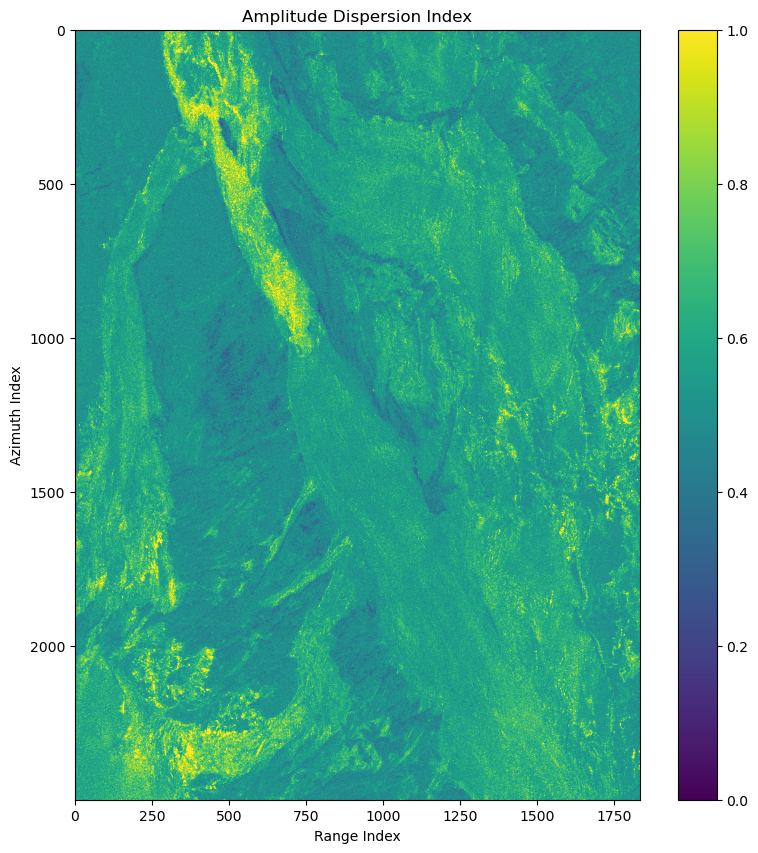

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(adi_cpu,vmin=0,vmax=1)
ax.set(title='Amplitude Dispersion Index',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()